# Model Training

In [37]:
import torch, torchvision
from torchvision import datasets, transforms

In [38]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

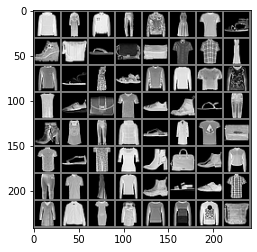

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [40]:
from torch import nn, optim
import torch.nn.functional as F

In [41]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [42]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [43]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5143396099969777
Training loss: 0.3934363489910992
Training loss: 0.35587457121053995
Training loss: 0.3344820481039949
Training loss: 0.3190533255479102


In [68]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images:', (
    100 * correct / total))
accuracy = 100 * correct / total

Accuracy of the network on the 10000 test images: 85.97


In [45]:
torch.save(model.state_dict(), 'model.ckpt')

# Pruning

In [46]:
# Loading a model to a seperate classifier
pruned_model = Classifier()
pruned_model.load_state_dict(torch.load('model.ckpt'))

<All keys matched successfully>

In [47]:
# Show Model State Dictionary
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([256, 784])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([128, 256])
fc2.bias 	 torch.Size([128])
fc3.weight 	 torch.Size([64, 128])
fc3.bias 	 torch.Size([64])
fc4.weight 	 torch.Size([10, 64])
fc4.bias 	 torch.Size([10])


In [48]:
def get_total_parameters_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_pruned_parameters_countget_pruned_parameters_count(pruned_model):
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    return params

In [49]:
total_params_count = get_pruned_parameters_count(model)
print('Total parameters:', total_params_count)

Total parameters: 242762


In [62]:
from torch.nn.utils import prune
pruning_percenatage = 0.40
parameters_to_prune = (
    (pruned_model.fc1, 'weight'),
    (pruned_model.fc2, 'weight'),
    (pruned_model.fc3, 'weight'),
    (pruned_model.fc4, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=pruning_percenatage, # Specifying the percentage
)

In [63]:
prune.remove(pruned_model.fc1, 'weight')
prune.remove(pruned_model.fc2, 'weight')
prune.remove(pruned_model.fc3, 'weight')
prune.remove(pruned_model.fc4, 'weight')

Linear(in_features=64, out_features=10, bias=True)

In [64]:
pruned_model_param_count = get_pruned_parameters_count(pruned_model)
print('Original Model paramete count:', total_params_count)
print('Pruned Model parameter count:', pruned_model_param_count)
print(f'Compressed Percentage: {(100 - (pruned_model_param_count / total_params_count) * 100)}%')

Original Model paramete count: 242762
Pruned Model parameter count: 145840
Compressed Percentage: 39.92469991184782%


In [70]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = pruned_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the Pruned Model on the 10000 test images:', (
    100 * correct / total))
print('Accuracy of the Original Model on the 10000 test images', accuracy)

Accuracy of the Pruned Model on the 10000 test images: 86.01
Accuracy of the Original Model on the 10000 test images 85.97
